### Replicating a ML research paper 

#### Vision Transformers ---> https://arxiv.org/abs/2010.11929

In [1]:
## Importing packages and scripts

import torch
import torchvision
from torchvision import transforms
from torchinfo import summary
import random
import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available() else "cpu"

from going_modular import data_setup,engine
from helper_functions import download_data,set_seeds,plot_loss_curves

In [2]:
# Get the data

# specify the directory
image_path= "data/pizza_steak_sushi/"
train_dir= f"{image_path}train"
test_dir= f"{image_path}test"
train_dir,test_dir

('data/pizza_steak_sushi/train', 'data/pizza_steak_sushi/test')

In [4]:
### Setup the transform according the paper

IMG_SIZE=224 # Table 3 from the ViT paper

manual_transforms= transforms.Compose([transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
                                       transforms.ToTensor()
                                       ])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [5]:
## Create DataLoaders

BATCH_SIZE=32 # The paper uses 4096, may be be too big for our hardware let's use 32 and scale up when needed

train_dataloader,test_dataloader,num_classes= data_setup.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=manual_transforms,
                                                                            batch_size=BATCH_SIZE)

train_dataloader,test_dataloader,num_classes

(<torch.utils.data.dataloader.DataLoader at 0x105f4e970>,
 ['pizza', 'steak', 'sushi'])

In [6]:
len(train_dataloader),len(test_dataloader),num_classes

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
# Check the length of the dataloaders and the lables

sample_img,sample_label= next(iter(train_dataloader))
img,label= sample_img[1],sample_label[1]
img.shape,label

(torch.Size([3, 224, 224]), tensor(0))

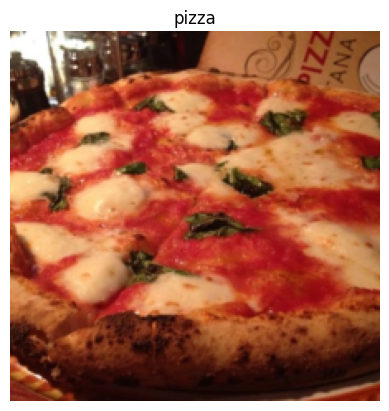

In [8]:
plt.imshow(img.permute(1,2,0));
plt.title(num_classes[label]);
plt.axis(False);

#### Replicating ViT: Overview 

Break down the research paper into smaller pieces: 

* **Input** : What goes into the model?
* **Output** : What does the model output?
* **Layer** : Takes an input manipulates it with a function (self-attention,conv,or maxpool etc)
* **Blocks** : Collection of layers
* **Model** : Collection of blocks

#### ViT Architecture Overview

![](ViT_architecture.png)

#### Let's breakdown the ViT architecture into equations

![](ViT_equations.png)



#### First Equation: Input
 
x1_p,x2_p,....xn_p ----> Images patches with size 16 x 16

x1_pE,x2_pE,.....xn_pE -----> Images patches converted into path embeddings

x_class -----> The learnable classification token

E_pos -----> Position Embedding


![](ViT_Equation1_1.png)

![](ViT_Equation1_2.png)

In pseudocode:

```python
x_input = [class_token, image_patch1,image_patch2,....image_patchN] + [class_token_pos,image_patch1_pos....image_patchn_pos]
```


#### Second & Thrid Equation: Multi-Head Self-Attention and MLP


![](ViT_Equation2&3.png)

```python
# Equation 2
x_output_MSA_block= MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block= mlp_LAYER(LN_layer(x_output)) + x_output_MSA_block
```


#### Fourth Equation: Output

![](ViT_Equation4.png)

pesudocode:

```python
# Equation 4
y = Linear_Layer(LN_layer(x_output_MLP_block)) 
```

#### Model Variants Table

![](ViT_model_variants.png)


* All the variants have the same model architecture, but vary in layers
* Layers- the number of transformer encoder layer
* Hidden Size $D$ - the embedding size throughout the architecture
* MLP - No: of hidden units in MLP
* Head - No: of multi-head self attention in the MSA block

#### Implementing Equation 1

Input Shape: H x W x C (height x width x color_channels)

Output Shape: N x (P^2 . C)

* H = height
* W = width
* C = color channels 
* P = patch size
* N = number of patches = (height*width)/P**2
* D = constant latent vector = embedding dimension 

In [9]:
height= 224
width =224
color_channels= 3
patch_size= 16

no_of_patches = int((height * width)/ patch_size**2)
no_of_patches

196

In [10]:
# Calculating input and output shapes

embedding_layer_input_shape = (height,width,color_channels)

embedding_layer_output_shape= (no_of_patches,(patch_size**2 * color_channels)) 

print(f"Input Embedding Size (single 2D Image): {embedding_layer_input_shape}")
print(f"Output Embedding Size (sequence of patches): {embedding_layer_output_shape}") # (number of patches,embedding dimension)

Input Embedding Size (single 2D Image): (224, 224, 3)
Output Embedding Size (sequence of patches): (196, 768)


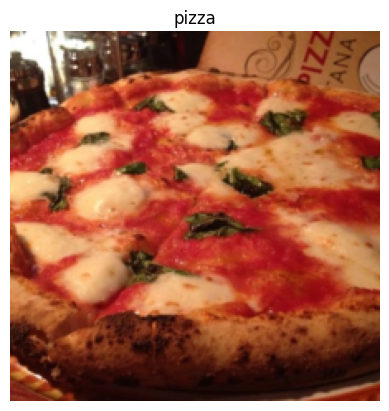

In [11]:
### Turning a single image into patches 

plt.imshow(img.permute(1,2,0))
plt.title(num_classes[label])
plt.axis(False);

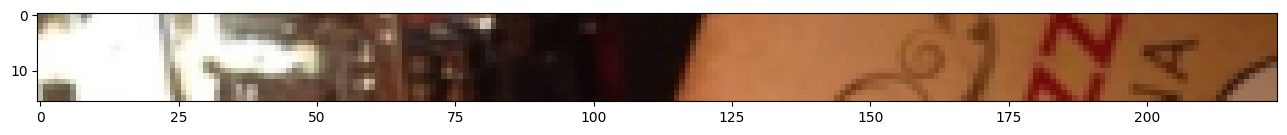

In [12]:
image_permuted= img.permute(1,2,0)
nrow= 16
ncolumn=16
patch_size=16

plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

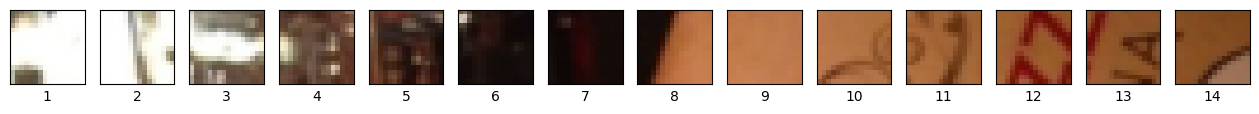

In [13]:
# Setup up patches for the top row of the image
img_size=224
patch_size=16
num_patches= img_size/patch_size
assert img_size % patch_size==0,"Image size must be divisble by patch size"

fig,axs= plt.subplots(nrows=1,
                      ncols=img_size//patch_size,
                      sharex=True,sharey=True,
                      figsize=(patch_size,patch_size)) 

# Iterate through number of patches in the top row

for i,patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Text(0.5, 0.98, 'pizza --> Patchified')

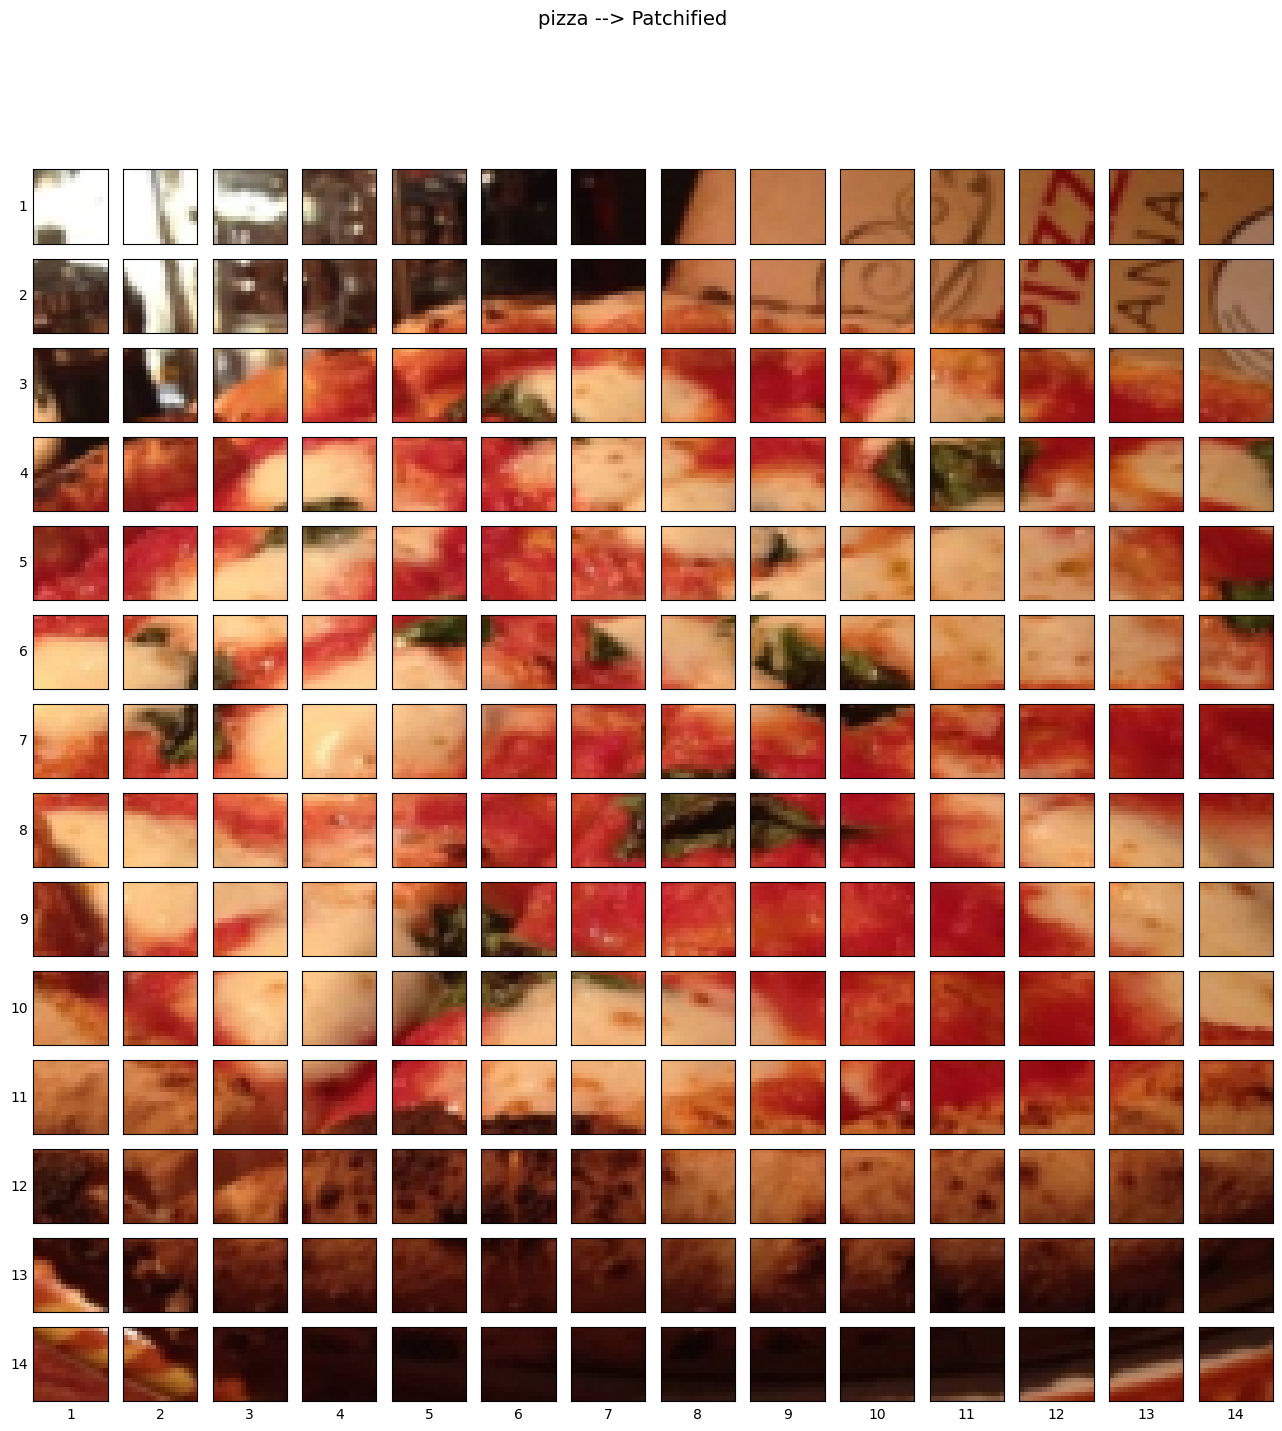

In [14]:
# Setup up patches for the entire image
img_size=224
patch_size=16
num_patches= img_size/patch_size
assert img_size % patch_size==0,"Image size must be divisble by patch size"

fig,axs= plt.subplots(nrows=img_size//patch_size,
                      ncols=img_size//patch_size,
                      sharex=True,sharey=True,
                      figsize=(patch_size,patch_size)) 

# Iterate through number of patches in the top row

for i,patch_height in enumerate(range(0,img_size,patch_size)):
    for j,patch_width in enumerate(range(0,img_size,patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                       patch_width:patch_width+patch_size,:])
        axs[i,j].set_ylabel(i+1,rotation="horizontal",horizontalalignment="right",verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f"{num_classes[label]} --> Patchified", fontsize=14)

In [15]:
# Let's get the embeddings of the image patches using a Conv2D layer from pytorch

#Let's first create the Conv2d layer
conv2d_embedding= torch.nn.Conv2d(in_channels=3, # RGB
                                  out_channels=embedding_layer_output_shape[1], # 768 the required embeding size D for ViT Base
                                  stride=patch_size, # 16
                                  kernel_size=patch_size) # 16

#Let's pass in a sample image and check the shape
embedding= conv2d_embedding(img.unsqueeze(0)) # Adding a batch dimension 
print(f"Embedding Shape: {embedding.shape}") 
# We have got the right dimensions, 768 is the embedding size, 14 is the height and 14 is the width of the embedding

# Let's Flatten the the embedding to obtain a series of patches/input sequences in the form of 1D embeddings as per the paper

flatten_layer= torch.nn.Flatten(start_dim=2,end_dim=3) 
flatten_reshaped= flatten_layer(embedding).permute(0,2,1)
print(f"1D representation of the embedding:{flatten_reshaped.shape}") 
# We have obtained the required 1D represenation of the embedding, we want (no:of patches,embedding dim)

Embedding Shape: torch.Size([1, 768, 14, 14])
1D representation of the embedding:torch.Size([1, 196, 768])


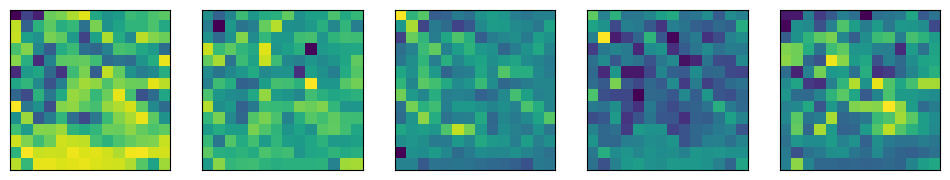

In [16]:
### Lets visualize the feature maps/embeddings from the Conv2d layer

import random

random_indices= random.sample(range(0,768),k=5)

# Create a plot 

fig,axs= plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i,idx in enumerate(random_indices):
    conv_map= embedding[:,idx,:,:]
    axs[i].imshow(conv_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



Text(0.5, 1.0, '1D Feature Map')

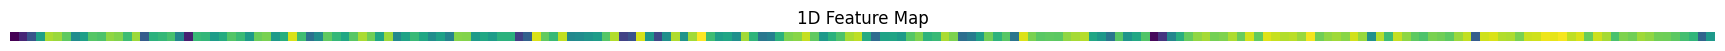

In [17]:
flattened_feature_map= flatten_reshaped[:,:,0]

plt.figure(figsize=(22,22))
plt.imshow(flattened_feature_map.detach().numpy())
plt.axis(False)
plt.title("1D Feature Map")

In [18]:
### Lets create a input embedding layer class by subclassing torch.nn

class embedding_layer(torch.nn.Module):
    
    def __init__(self,input_shape,output_shape,patch_size):
        super().__init__()
        self.out_shape= output_shape
        self.patch_size= patch_size
        self.input_layer_stack = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels=input_shape,
                            out_channels=output_shape,
                            kernel_size=patch_size,
                            stride=patch_size),
                                        
            torch.nn.Flatten(start_dim=2,
                                end_dim=3))
        
    def forward(self,x):
        
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size==0, f"Input image size must be divisble by patch size, image size: {image_resolution}, patch size: {patch_size}"
        fwd= self.input_layer_stack(x)
        change_dim= fwd.permute(0,2,1)
       
        return change_dim
    

In [19]:
embedding_layer= embedding_layer(input_shape=3,output_shape=768,patch_size=16)
embedding_layer_output= embedding_layer(img.unsqueeze(0))
embedding_layer_output.shape

torch.Size([1, 196, 768])

#### Let's create the class token - As per the paper we have to prepend the class token to the path embedding tensor


In [20]:
batch_size= embedding_layer_output.shape[0]
embedding_dimension= embedding_layer_output.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [21]:
class_token= torch.nn.Parameter(torch.randn(batch_size,1,embedding_dimension),requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [22]:
patch_embedding_with_class_token= torch.cat((class_token,embedding_layer_output),dim=1)
patch_embedding_with_class_token.shape 
# after adding the class embedding the embedding dimension went from (1,196,768) -> (1,197,768)

torch.Size([1, 197, 768])

In [23]:
#### Let's create the positional embeddings now

no_of_patches, embedding_dimension

(196, 768)

In [24]:
positional_embedding= torch.nn.Parameter(torch.randn(1,int(no_of_patches+1),embedding_dimension),
                                         requires_grad=True)
positional_embedding.shape

torch.Size([1, 197, 768])

In [25]:
# As per the question lets add the positional embedding to the patch_embedding_with_class_token

final_embedding = patch_embedding_with_class_token + positional_embedding
final_embedding,final_embedding.shape# There wont be any shape change since we are two tensors 

(tensor([[[-0.4780, -1.3044, -0.7456,  ..., -0.1389,  0.1779, -0.0032],
          [ 1.0492,  1.1524, -1.5152,  ...,  1.6320, -0.4583,  0.1885],
          [-0.2020,  1.6009,  0.9471,  ...,  0.5224,  0.5367,  0.7286],
          ...,
          [ 2.0573, -0.6936, -2.1461,  ...,  1.7694,  0.3887, -1.1803],
          [ 1.2131, -0.4067,  0.3992,  ...,  0.2635,  0.8226, -1.4294],
          [ 0.3167,  1.3471,  1.2047,  ..., -0.7253, -1.8251, -0.4333]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

##### Now let's put everything together in a single class/ lets put everything in the existing `input_embedding_layer` class

Basic Overview of the Input Embedding Layer ---> [class_token; patch_embeddings]+ positional_embeddings

In [26]:
### Lets create a input embedding layer class by subclassing torch.nn

class input_embedding_layer(torch.nn.Module):
    
    def __init__(self,input_shape,
                 output_shape,patch_size,
                 number_of_patches,
                 embedding_dropout):
        
        super().__init__()

        self.out_shape= output_shape
        self.patch_size= patch_size

        self.input_layer_stack = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels=input_shape,
                            out_channels=output_shape,
                            kernel_size=patch_size,
                            stride=patch_size),
                                        
            torch.nn.Flatten(start_dim=2,
                                end_dim=3))
        
        self.class_token= torch.nn.Parameter(torch.randn(1,1,
                                                         output_shape),
                                                         requires_grad=True)
        
        self.positional_embedding= torch.nn.Parameter(torch.randn(1,int(number_of_patches+1),
                                                                  output_shape),
                                                                  requires_grad=True)
        
        self.embedding_dropout= torch.nn.Dropout(p=embedding_dropout)
        
    def forward(self,x):
        image_resolution = x.shape[-1]
        batch_size = x.shape[0]
        assert image_resolution % patch_size==0, f"Input image size must be divisble by patch size, image size: {image_resolution}, patch size: {patch_size}"
        fwd= self.input_layer_stack(x)
        change_dim= fwd.permute(0,2,1)
        class_token = self.class_token.expand(batch_size, -1, -1)
        embedding_with_class_token= torch.cat((class_token,change_dim),dim=1)
        embedding_with_pos_embedding = embedding_with_class_token + self.positional_embedding
        embedding_dropout= self.embedding_dropout(embedding_with_pos_embedding)
       
        return embedding_dropout
    

In [27]:
# Let's check our inputs before we pass it into the class

embedding_dropout=0.1

print(f"Embedding Dimension: {embedding_dimension}")
print(f"Patch Size: {patch_size}")
print(f"Batch Size: {batch_size}")
print(f"Number of Patches: {no_of_patches}")
print(f"Embedding Dropout: {embedding_dropout}")

Embedding Dimension: 768
Patch Size: 16
Batch Size: 1
Number of Patches: 196
Embedding Dropout: 0.1


In [28]:
# Instantiate the input embedding layer class 

final_embedding_layer= input_embedding_layer(input_shape=3,output_shape=embedding_dimension,
                                             patch_size=patch_size,number_of_patches=no_of_patches,
                                             embedding_dropout=embedding_dropout)

In [29]:
# Let's pass in a image tensor and see if everything checks out with the input embedding layer class
test_pass= torch.randn(size=(32,3,224,224))
embedding_layer_pass= final_embedding_layer(test_pass)
embedding_layer_pass.shape  # Everything checks out and we get the expected embedding output size (1,197,768)

torch.Size([32, 197, 768])

#### Equation 2: MSA Block

In [30]:
# Lets create the Multi Head Attention Block 
class MultiHeadAttentionBlock(torch.nn.Module):

    def __init__(self,embedding_dim:int,num_heads:int,attention_dropout:int):
        super().__init__()

        # Layer-Norm (LM) layer
        self.layer_norm= torch.nn.LayerNorm(normalized_shape=embedding_dim)

        # Multi Head Attention Layer
        self.multihead_attn= torch.nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attention_dropout,
                                                         batch_first=True)
        
    def forward(self,x):
        # Forward Method
        x= self.layer_norm(x)
        msa_output,_= self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)

        return msa_output

In [31]:
# Instantiate the MSA class above 
num_heads=12
attention_dropout= 0

msa_block = MultiHeadAttentionBlock(embedding_dim=embedding_dimension,
                                    num_heads=num_heads,
                                    attention_dropout=attention_dropout)

In [32]:
## Pass in the output from the input embedding layer for a check
msa_output= msa_block(embedding_layer_pass)

In [33]:
# The shape remains the same, but the values have changed
msa_output.shape

torch.Size([32, 197, 768])

In [34]:
## Let's create the MLP block

class MLPBlock(torch.nn.Module):
    def __init__(self,embedding_dim:int,mlp_size:int,dropout:int):

        super().__init__()
        # LN layer
        self.layer_norm= torch.nn.LayerNorm(normalized_shape=embedding_dim)
        # MLP layer with GELU and dropout
        self.mlp_layer= torch.nn.Sequential(torch.nn.Linear(in_features=embedding_dim,out_features=mlp_size),
                                      torch.nn.GELU(),
                                      torch.nn.Dropout(p=dropout),
                                      torch.nn.Linear(in_features=mlp_size,out_features=embedding_dim),
                                      torch.nn.Dropout(p=dropout)
                                      )
    # forward method
    def forward(self,x):
        x= self.layer_norm(x)
        x= self.mlp_layer(x)
        return x

In [35]:
# Instantiate the MLPBlock

mlp_block= MLPBlock(embedding_dim=embedding_dimension,
                    mlp_size=3072,
                    dropout=0.1)

mlp_pass = mlp_block(msa_output) # pass in the output from the MSA block
mlp_pass.shape

torch.Size([32, 197, 768])

#### Building the Transformer Encoder Block

x_input ---> Embedding Block---> MSA_Block ---> [MSA_block_output + Embedding Block Output] ---> MLP_Block ---> [MLP_Block + MSA_block_output]

In [36]:
class TransformerEncoderBlock(torch.nn.Module):

    def __init__(self,embedding_dim:int,num_heads:int,attention_dropout:int,mlp_size:int,mlp_dropout:int):
        super().__init__()

        self.msa = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            attention_dropout=attention_dropout)
        
        self.mlp= MLPBlock(embedding_dim=embedding_dim,
                           mlp_size=mlp_size,
                           dropout=mlp_dropout)
        
    def forward(self,x):
        x= self.msa(x) +x
        x= self.mlp(x) +x
        return x

In [37]:
transformer_encoder_block = TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                    num_heads=12,attention_dropout=0,
                                                    mlp_size=3072,mlp_dropout=0.1)
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttentionBlock (msa)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [38]:
### Creating the entire ViT architecture

class ViT(torch.nn.Module):

    def __init__(self,input_shape,embedding_dimension,
                 patch_size,number_of_patches,num_heads,
                 attention_dropout,embedding_dropout,mlp_size,
                 dropout,num_output_classes,num_transformer_layers):
        
        super().__init__()
        
        # Input Embedding Layer

        self.input_embedding_layer= input_embedding_layer(input_shape=input_shape,
                                                          output_shape=embedding_dimension,
                                                          patch_size=patch_size,
                                                          number_of_patches=number_of_patches,
                                                          embedding_dropout=embedding_dropout)
        
        self.transformer_encoder_block= torch.nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                                 num_heads=num_heads,
                                                                 attention_dropout=attention_dropout,
                                                                 mlp_size=mlp_size,mlp_dropout=dropout) for _ in range(num_transformer_layers)])
        
        self.classifier = torch.nn.Sequential(torch.nn.LayerNorm(normalized_shape=embedding_dimension),
                                              torch.nn.Linear(in_features=embedding_dimension,
                                                              out_features=num_output_classes))
        
    def forward(self,x):

        x= self.input_embedding_layer(x)
        x= self.transformer_encoder_block(x)
        x= self.classifier(x[:,0])

        return x

In [39]:
# Let's check the input arguments before instantiating the ViT class

input_size =3
num_heads=12
attn_dropout=0.1
mlp_size= 3072
dropout= 0.1
num_classes = 3
num_transformer_layers= 12
batch_size=1


print(f"Input Size: {input_size}")
print(f"Embedding Size: {embedding_dimension}")
print(f"Patch Size: {patch_size}")
print(f"Batch Size: {batch_size}")
print(f"Number of Patches: {no_of_patches}")
print(f"Number of Attention Heads:{num_heads}")
print(f"Attention Dropout Probability: {attn_dropout}")
print(f"Embedding Dropout: {embedding_dropout}")
print(f"MLP Layer Size: {mlp_size}")
print(f"Dropout Probability For MLP Layer: {dropout}")
print(f"Number of Classes {num_classes}")

Input Size: 3
Embedding Size: 768
Patch Size: 16
Batch Size: 1
Number of Patches: 196
Number of Attention Heads:12
Attention Dropout Probability: 0.1
Embedding Dropout: 0.1
MLP Layer Size: 3072
Dropout Probability For MLP Layer: 0.1
Number of Classes 3


In [40]:
ViT_model = ViT(input_shape=input_size,
                embedding_dimension=embedding_dimension,
                patch_size=patch_size,
                number_of_patches=no_of_patches,
                num_heads=num_heads,
                attention_dropout=attn_dropout,
                embedding_dropout=embedding_dropout,
                mlp_size=mlp_size,dropout=dropout,
                num_output_classes=num_classes,
                num_transformer_layers=num_transformer_layers
                ).to(device)

In [41]:
num_classes

3

In [42]:
ViT_model(img.unsqueeze(0).to(device)).shape

torch.Size([1, 3])

In [43]:
# sample forward pass on the new ViT class

summary(model=ViT_model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"],device=device)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               --                   True
├─input_embedding_layer (input_embedding_layer)              [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Sequential (input_layer_stack)                        [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten (1)                                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder_block)                     [1, 197, 768]        [1, 197, 768] 

#### Let's Train the ViT Model

In [44]:
# Instantiate Model for training with batch size as 32

ViTModel = ViT(input_shape=input_size,
                embedding_dimension=embedding_dimension,
                patch_size=patch_size,
                number_of_patches=no_of_patches,
                num_heads=num_heads,
                attention_dropout=attn_dropout,
                embedding_dropout=embedding_dropout,
                mlp_size=mlp_size,dropout=dropout,
                num_output_classes=num_classes,
                num_transformer_layers=num_transformer_layers
                ).to(device)

# Setup up optimizer 

optimizer= torch.optim.Adam(params=ViTModel.parameters(),
                            lr= 3e-3,betas=(0.9,0.999),
                            weight_decay=0.3)

# Setup Loss Function

loss_function= torch.nn.CrossEntropyLoss()

In [45]:
sample_pass = torch.randn((32,3,224,224)).to(device)

ViTModel(sample_pass).shape

torch.Size([32, 3])

In [46]:
# train the model

set_seeds()
results = engine.train(model=ViTModel,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_function,
                       epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0231 | train_acc: 0.6367 | test_loss: 6.6759 | test_acc: 0.5417
Epoch: 2 | train_loss: 3.3322 | train_acc: 0.6523 | test_loss: 4.1229 | test_acc: 0.5417
Epoch: 3 | train_loss: 4.2316 | train_acc: 0.3047 | test_loss: 3.6266 | test_acc: 0.5417
Epoch: 4 | train_loss: 5.3853 | train_acc: 0.0547 | test_loss: 1.0504 | test_acc: 0.5417
Epoch: 5 | train_loss: 2.2469 | train_acc: 0.1797 | test_loss: 2.1233 | test_acc: 0.5417
Epoch: 6 | train_loss: 2.1955 | train_acc: 0.3477 | test_loss: 2.8408 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2863 | train_acc: 0.7148 | test_loss: 3.7728 | test_acc: 0.5417
Epoch: 8 | train_loss: 2.4292 | train_acc: 0.4023 | test_loss: 2.9398 | test_acc: 0.5417
Epoch: 9 | train_loss: 2.9312 | train_acc: 0.2773 | test_loss: 1.8038 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.8349 | train_acc: 0.5273 | test_loss: 3.1356 | test_acc: 0.5417


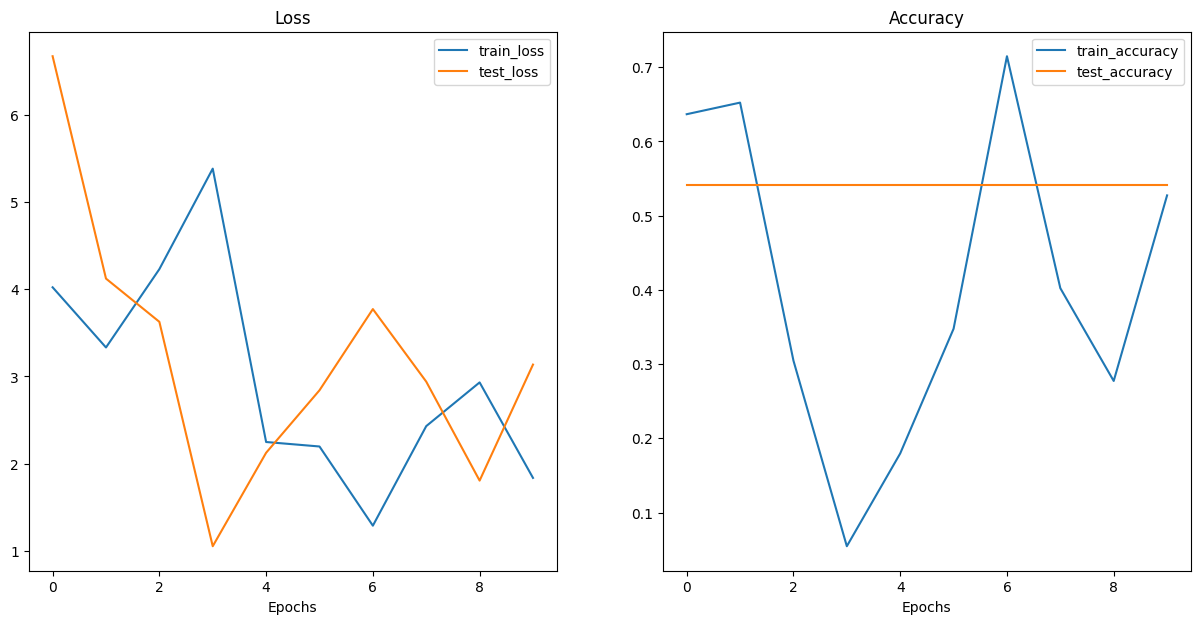

In [47]:
plot_loss_curves(results)

#### The loss and accuracy curves tell us that the model is clearly overfiiting 

Reasons:

* ViT is a big model with around 86 million parameters, we just have 225 training images
* We require a lot more data to train the model 
* In the ViT paper, ViT is trained on millions of images 
* Also, techniques like Learning Rate Warmup, Learning rate decay and gradient clipping are used to prevent overfitting 
* However, these methods are ineffective if we dont have enough data and compute resources to train a 86 million parameter model
* The ViT model in the ViT paper took 30 days to train with TPU V3 - 8 cores thats around $5000 for on demand usage

Solution:

* When we have less data, we can leverage Transfer Learning
* Transfer Learnig allows us to transfer/get the weights of a well trained model aka a pre trained model
* These pre trained models are already trained to generally perform well for a specific use case (CV,NLP etc)
* PyTorch has inbuilt pre-trained models and ViT is one of them, which we can use and get better results 


#### Transfer Learning 

In [63]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT will give us the best weights

pretrained_vit= torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device) # call the model from torchvision and update its weights with the DEFAULT ViT weights we got from PyTorch

# lets freeze base layers, because the all the layers already have the trained weights. We will modify the MLP head block and set the output features to the number of classess we have

for params in pretrained_vit.parameters():
    params.requires_grad=False

set_seeds()


pretrained_vit.heads= torch.nn.Linear(in_features=embedding_dimension,out_features=len(num_classes),device=device)

In [64]:
# Lets automatically apply transforms specific to the pretrained model on the data we have

# get the automatic transform

pretrained_vit_transforms= pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [65]:
# Create dataloaders with the automatic transforms 
pretrained_train_dataloader,pretrained_test_dataloader,num_classes= data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                  test_dir=test_dir,
                                                                                                  transform=pretrained_vit_transforms,
                                                                                                  batch_size=BATCH_SIZE)

pretrained_train_dataloader,pretrained_test_dataloader,num_classes

(<torch.utils.data.dataloader.DataLoader at 0x14f45f310>,
 ['pizza', 'steak', 'sushi'])

In [66]:
## Train the pretrained model with our data 

# set the optimizer 

optimizer_for_pretrained_model= torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)

set_seeds()

pretrained_vit_results= engine.train(model=pretrained_vit,train_dataloader=pretrained_train_dataloader,
                                     test_dataloader=pretrained_test_dataloader,optimizer=optimizer_for_pretrained_model,
                                     loss_fn=loss_function,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1841 | train_acc: 0.3750 | test_loss: 0.9467 | test_acc: 0.4792
Epoch: 2 | train_loss: 0.5159 | train_acc: 0.8750 | test_loss: 0.5590 | test_acc: 0.7244
Epoch: 3 | train_loss: 0.3179 | train_acc: 0.9492 | test_loss: 0.3672 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.2399 | train_acc: 0.9570 | test_loss: 0.2878 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.1997 | train_acc: 0.9609 | test_loss: 0.2552 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.1735 | train_acc: 0.9648 | test_loss: 0.2411 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.1542 | train_acc: 0.9648 | test_loss: 0.2339 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.1392 | train_acc: 0.9727 | test_loss: 0.2286 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.1268 | train_acc: 0.9766 | test_loss: 0.2240 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1163 | train_acc: 0.9766 | test_loss: 0.2200 | test_acc: 0.9176


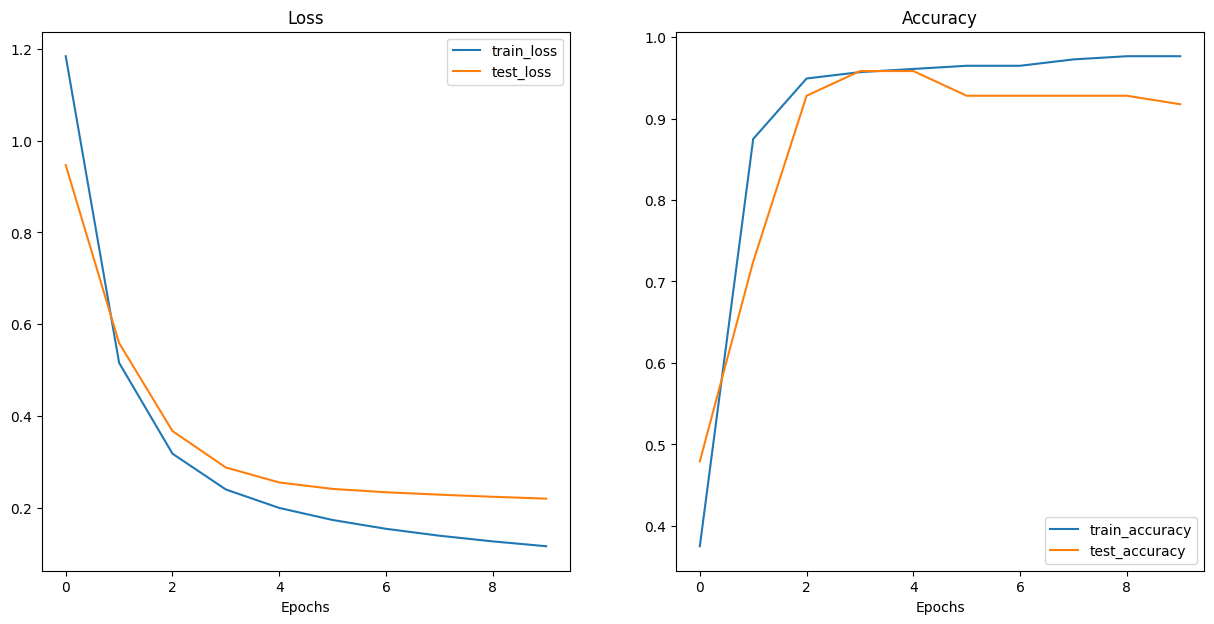

In [67]:
## Let's plot the loss and accuracy curves 

plot_loss_curves(pretrained_vit_results)

#### The loss and accuracy curves are looking great, the pretrained model performs really well on our dataset

The power of transfer learning!

In [98]:
### Let's do some predictions

import requests
from pathlib import Path
# Import function to make predictions on images and plot them


# Setup custom image path
custom_image_path = Path("/Users/vishal./PyTorch/prediction_sushi.jpg")
custom_image_path

PosixPath('/Users/vishal./PyTorch/prediction_sushi.jpg')

In [100]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "mps" if torch.backends.mps.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

     # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

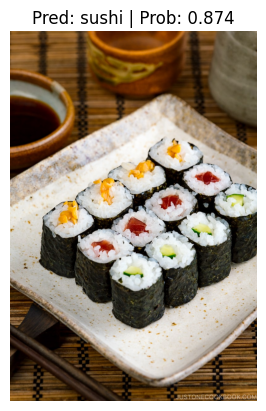

In [101]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=num_classes,
                    device=device)